In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Processed_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35123 entries, 0 to 35122
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  35123 non-null  int64  
 1   driver_uuid                 35123 non-null  object 
 2   geo_name                    35123 non-null  object 
 3   is_cash_trip                35123 non-null  bool   
 4   is_batch                    35123 non-null  bool   
 5   end_reason                  35123 non-null  object 
 6   trip_fare_in_lkr            35123 non-null  float64
 7   estimated_distance          35123 non-null  float64
 8   estimated_time              35123 non-null  float64
 9   fare_per_km                 35123 non-null  float64
 10  fare_per_min                35122 non-null  float64
 11  row_rank                    35122 non-null  float64
 12  delivery_hour_bin           35122 non-null  object 
 13  distance_bin                351

In [ ]:
df.dropna()

In [ ]:
df.head()

,Unnamed: 0,driver_uuid,geo_name,is_cash_trip,is_batch,end_reason,trip_fare_in_lkr,estimated_distance,estimated_time,fare_per_km,...,row_rank,delivery_hour_bin,distance_bin,estimated_time_bin,target,est_speed,fare_per_min_calc,driver_historical_acc_rate,geo_encoded,dist_ordinal
0,0,42345cdf-82dd-40ab-bb8f-4ada32c85d1f,CMB North,True,True,driver_rejected,121.070569,1.607284,12.266667,75.326168,...,1.0,Normal hours,0–2 km,10–20 min,0.0,0.121152,9.125922,0.625000,2.0,1.0
1,1,fe61ccaf-47ee-433d-b367-83bcc681c58e,CMBSouth,True,True,driver_rejected,226.573777,7.209843,21.588889,31.425618,...,1.0,Late night,6–10 km,20–30 min,0.0,0.319177,10.030320,0.584615,5.0,4.0
2,2,dbacb58b-921b-4acc-bf9b-425b0abb096e,CMB West,False,True,driver_rejected,60.144346,1.110445,8.158333,54.162402,...,1.0,Late night,0–2 km,0–10 min,0.0,0.121250,6.567172,0.659091,3.0,1.0
3,3,3e40d19e-68c2-4b00-9679-8e936e7987a6,"Malabe, Kaduwela, Biyagama",False,True,driver_rejected,250.811949,7.411423,23.525000,33.841267,...,1.0,Late night,6–10 km,20–30 min,0.0,0.302199,10.226787,0.708333,13.0,4.0
4,4,b9b9a52f-4049-448a-b675-2d802722259d,CMB West,False,True,driver_rejected,215.376905,6.661970,25.908333,32.329313,...,1.0,Evening peak,6–10 km,20–30 min,0.0,0.247580,8.004097,0.620000,3.0,4.0


Feature Enginering to mainly to the variable encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def engineer_features(df):
    new_df = df.copy()

    # Convert relevant columns to numeric, coercing errors to NaN
    cols_to_convert_to_numeric = ['estimated_distance', 'estimated_time', 'fare_per_km', 'fare_per_min']
    for col in cols_to_convert_to_numeric:
        new_df[col] = pd.to_numeric(new_df[col], errors='coerce')

    # Drop rows with NaN values introduced by coercion (or handle them otherwise)
    new_df.dropna(subset=cols_to_convert_to_numeric, inplace=True)

    # 1. Target: Binary classification
    new_df['target'] = (new_df['end_reason'] == 'driver_accepted').astype(int)

    # 2. Calculated Features (The "Signal" creators)
    # Speed proxy (km per minute)
    new_df['est_speed'] = new_df['estimated_distance'] / (new_df['estimated_time'] + 1) # +1 to avoid div by zero

    # Value of time
    new_df['fare_per_min_calc'] = new_df['trip_fare_in_lkr'] / (new_df['estimated_time'] + 1)

    # 3. Handle Driver Acceptance History (Target Encoding)
    # Using a simple mean for now (In a real scenario, use smoothing to prevent leakage)
    driver_means = new_df.groupby('driver_uuid')['target'].mean()
    new_df['driver_historical_acc_rate'] = new_df['driver_uuid'].map(driver_means)

    # 4. Handle Geographies
    # CMB North vs CMB South matters. Let's use Label Encoding for simple XGBoost input
    new_df['geo_encoded'] = LabelEncoder().fit_transform(new_df['geo_name'])

    # 5. Convert Bins to Ordinal Integers
    # Drivers view 0-2km as "Short", 6-10km as "Long"
    dist_map = {'0–2 km': 1, '2–4 km': 2, '4–6 km': 3, '6–10 km': 4, '10+ km': 5}
    new_df['dist_ordinal'] = new_df['distance_bin'].map(dist_map).fillna(0)

    return new_df

# Apply transformation
processed_df = engineer_features(df)

Numerical columns for distribution analysis: ['Unnamed: 0', 'trip_fare_in_lkr', 'estimated_distance', 'estimated_time', 'fare_per_km', 'fare_per_min', 'est_speed', 'fare_per_min_calc', 'driver_historical_acc_rate']


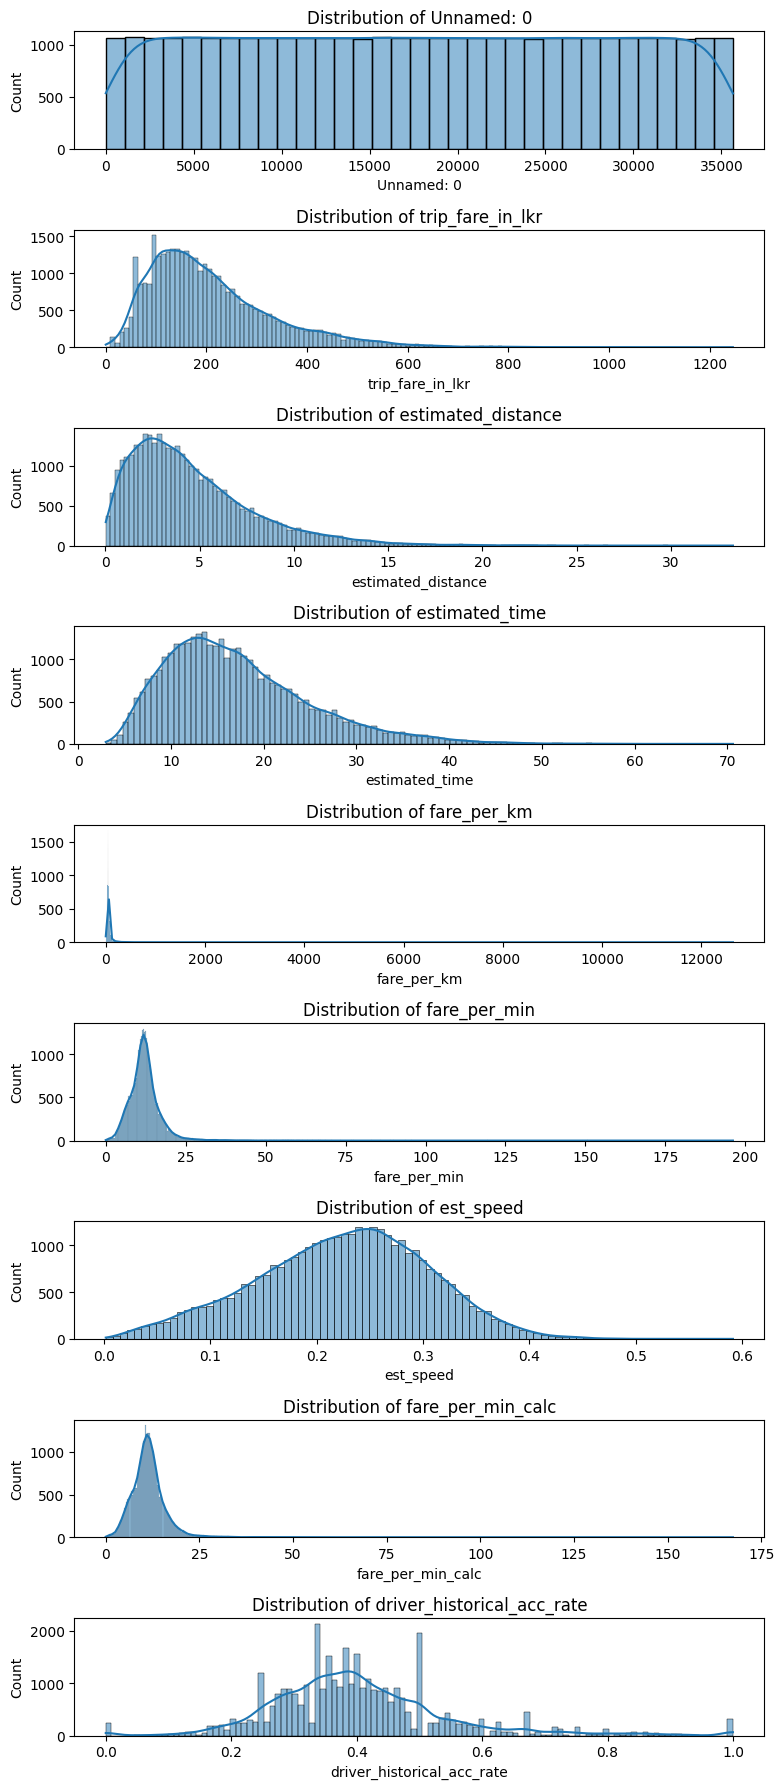

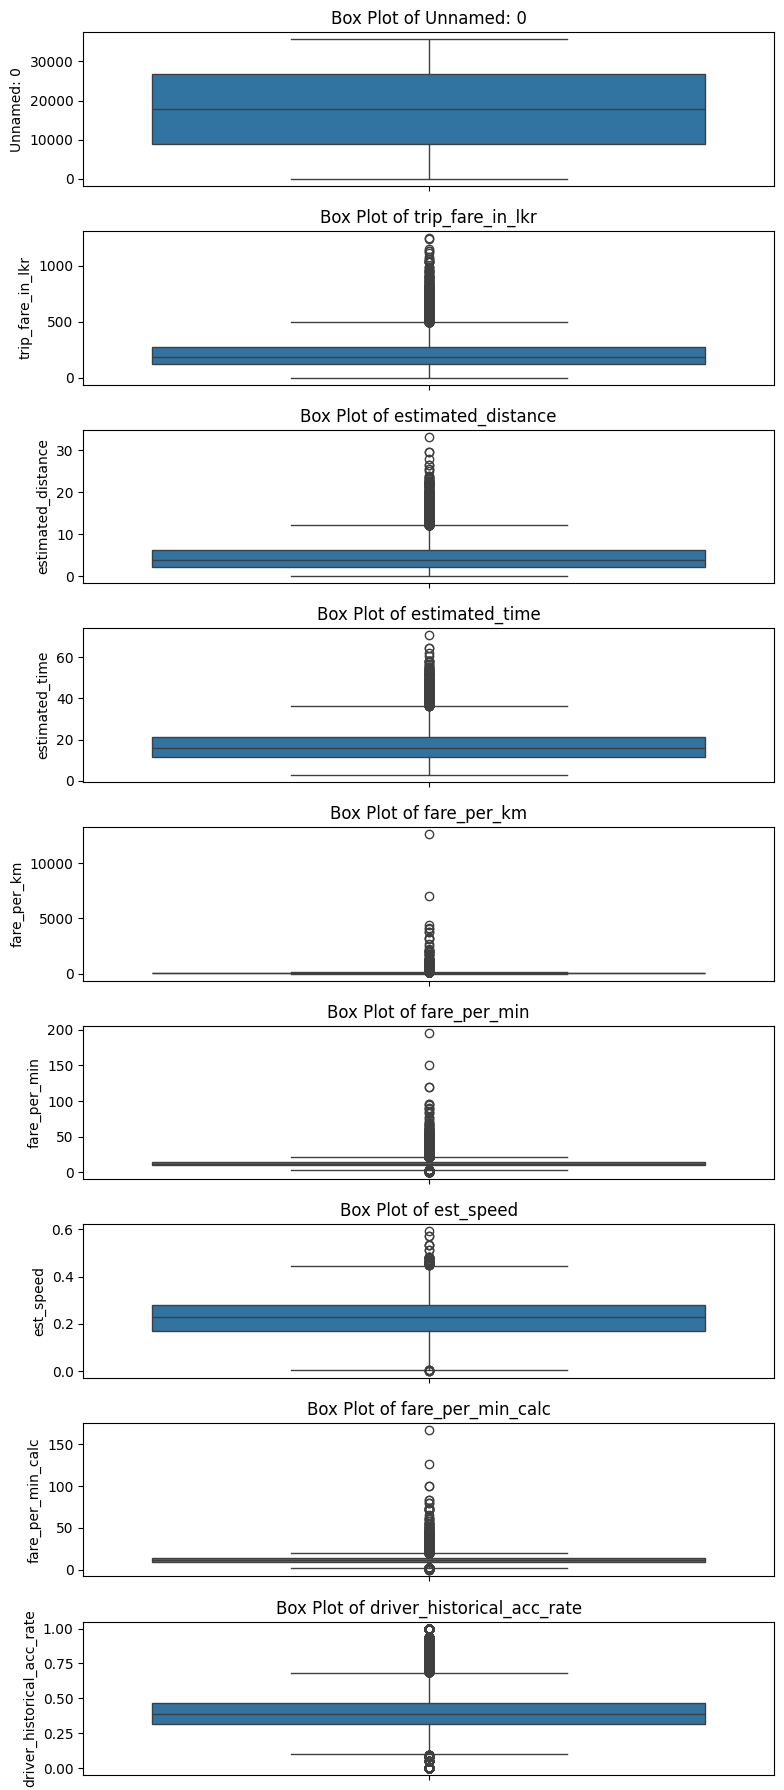

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Identify numerical columns
# Exclude 'target', 'geo_encoded', 'dist_ordinal' as they are already encoded/ordinal and 'row_rank' as it's constant
# 'is_cash_trip' and 'is_batch' are boolean, and while np.number includes bool, they are better treated separately or as categorical
numerical_cols = processed_df.select_dtypes(include=np.number).columns.tolist()

# Remove columns that are numerical but represent categorical/ordinal data or are constants
# 'target' is the target variable, its distribution will be analyzed separately
# 'geo_encoded' and 'dist_ordinal' are integer-encoded categorical/ordinal features
# 'row_rank' appears to be a constant based on describe output
exclude_from_hist_boxplot = ['target', 'geo_encoded', 'dist_ordinal', 'row_rank']
numerical_cols = [col for col in numerical_cols if col not in exclude_from_hist_boxplot]

print(f"Numerical columns for distribution analysis: {numerical_cols}")

# Plotting Histograms
plt.figure(figsize=(15, 2 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, 2*i + 1)
    sns.histplot(processed_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Plotting Box Plots
plt.figure(figsize=(15, 2 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, 2*i + 2)
    sns.boxplot(y=processed_df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

Categorical columns for distribution analysis: ['geo_name', 'is_cash_trip', 'is_batch', 'end_reason', 'delivery_hour_bin', 'distance_bin', 'estimated_time_bin']


/tmp/ipython-input-1030185400.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=processed_df, x=col, palette='viridis', order=processed_df[col].value_counts().index)
/tmp/ipython-input-1030185400.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=processed_df, x=col, palette='viridis', order=processed_df[col].value_counts().index)
/tmp/ipython-input-1030185400.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=processed_df, x=col, palette='viridis', order=processed_df[col].value_counts().index)
/tmp/ipython-input-

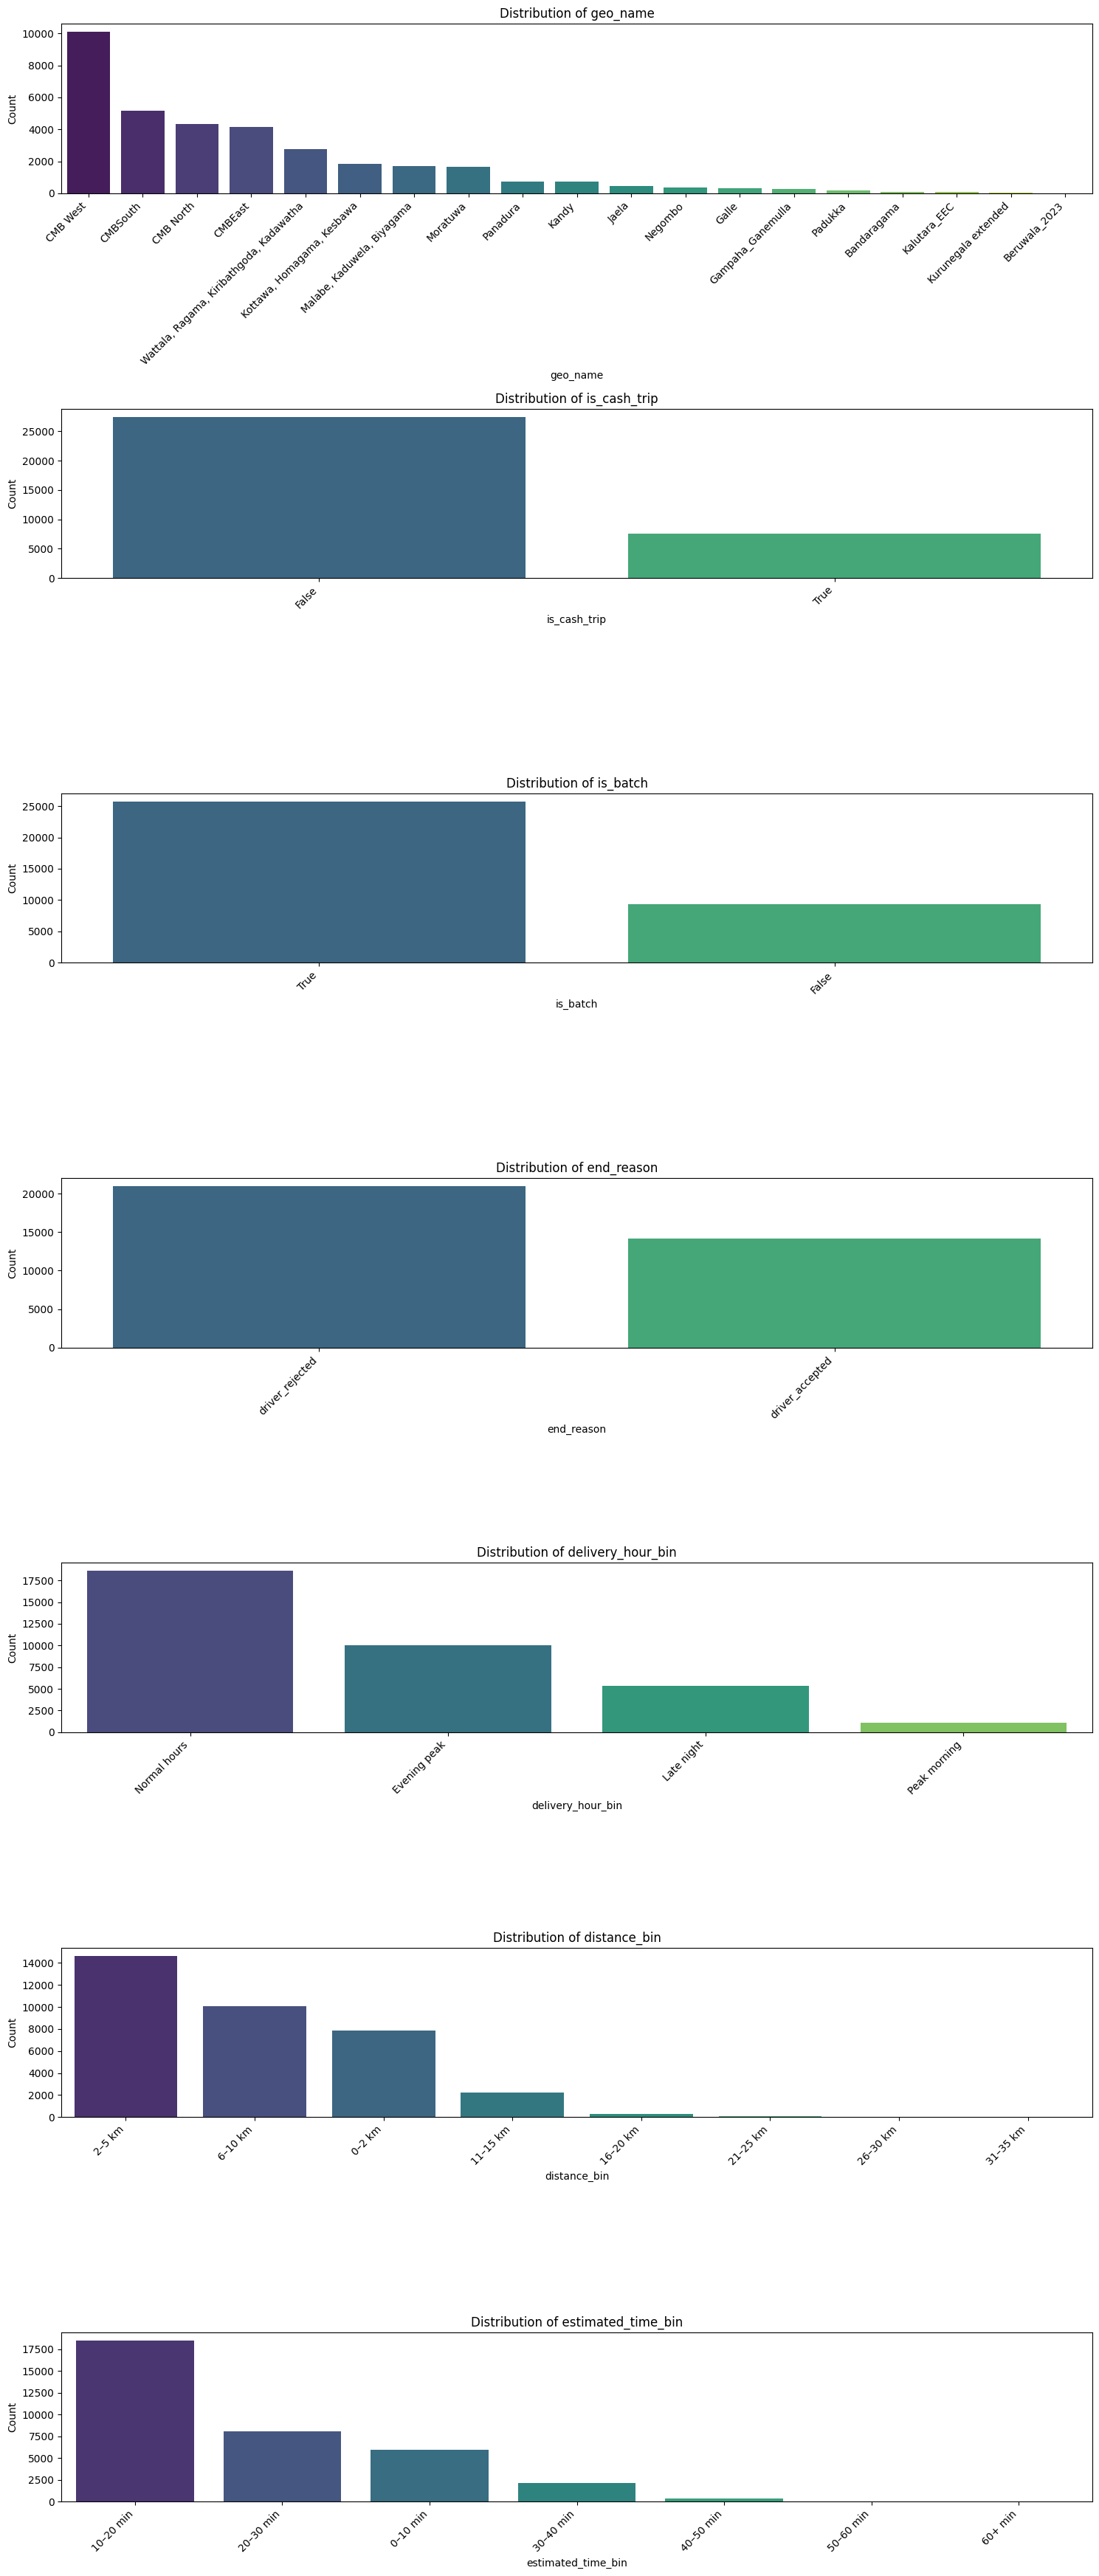

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported for plotting

# Identify categorical columns (object and bool dtypes)
categorical_cols = processed_df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Exclude 'driver_uuid' due to high cardinality
if 'driver_uuid' in categorical_cols:
    categorical_cols.remove('driver_uuid')

print(f"Categorical columns for distribution analysis: {categorical_cols}")

# Plotting Count Plots for each categorical column
plt.figure(figsize=(15, 5 * len(categorical_cols)))
for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.countplot(data=processed_df, x=col, palette='viridis', order=processed_df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Numerical features selected for correlation matrix: ['Unnamed: 0', 'trip_fare_in_lkr', 'estimated_distance', 'estimated_time', 'fare_per_km', 'fare_per_min', 'est_speed', 'fare_per_min_calc', 'driver_historical_acc_rate']


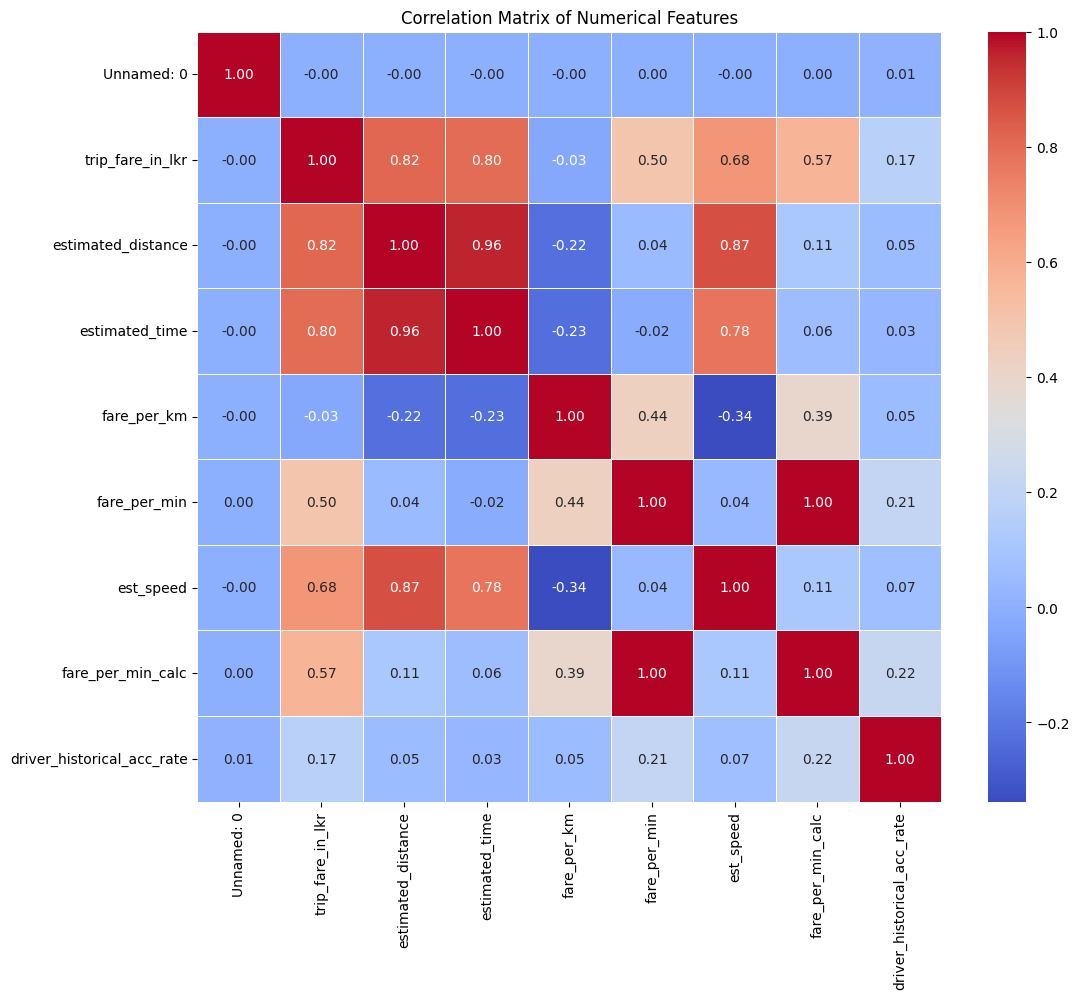

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Identify numerical columns for correlation analysis
# Exclude 'target', 'geo_encoded', 'dist_ordinal' as they are already encoded/ordinal and 'row_rank' as it's constant
# The boolean columns (`is_cash_trip`, `is_batch`) are also numerical (0/1) but are best kept separate or treated as categorical for correlation.
# For correlation, we'll focus on the truly continuous numerical features.

# Get all numerical columns (float64 and int64)
all_numerical_cols = processed_df.select_dtypes(include=np.number).columns.tolist()

# Exclude target and already encoded/ordinal features, and constant columns
exclude_from_correlation = ['target', 'geo_encoded', 'dist_ordinal', 'row_rank']

# Also exclude boolean columns if they were included by select_dtypes(include=np.number)
# They are technically numeric (0/1) but might distort continuous correlation heatmaps.
# However, for a comprehensive correlation, we can include them, but let's be explicit.
# For now, let's keep them if they are in the original numerical_cols list for previous plots
# The 'is_cash_trip' and 'is_batch' are boolean, which are automatically cast to numeric (0 or 1) for correlation.
# Let's include them in the correlation matrix as they are relevant features.

numerical_features_for_corr = [col for col in all_numerical_cols if col not in exclude_from_correlation]

print(f"Numerical features selected for correlation matrix: {numerical_features_for_corr}")

# Compute the correlation matrix
correlation_matrix = processed_df[numerical_features_for_corr].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

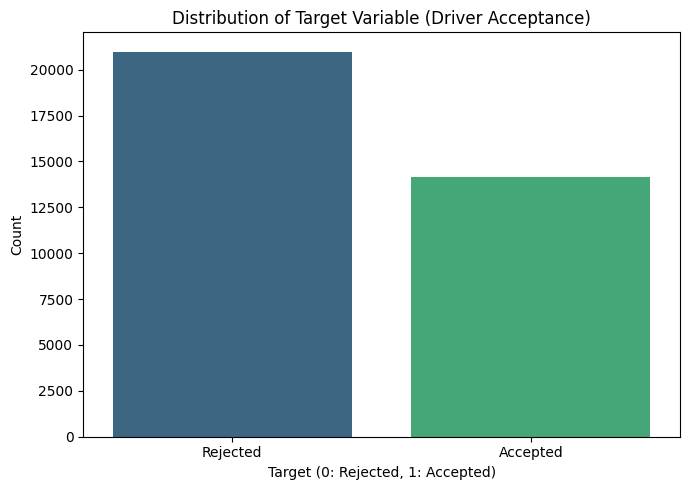

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable
plt.figure(figsize=(7, 5))
sns.countplot(data=processed_df, x='target', palette='viridis', hue='target', legend=False)
plt.title('Distribution of Target Variable (Driver Acceptance)')
plt.xlabel('Target (0: Rejected, 1: Accepted)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Rejected', 'Accepted'])
plt.tight_layout()
plt.show()

**Reasoning**:
To analyze the relationships between the target variable and other key numerical features, I will create box plots. These plots will show the distribution of selected numerical features for both accepted and rejected trips, helping to identify potential differences in their central tendency and spread.



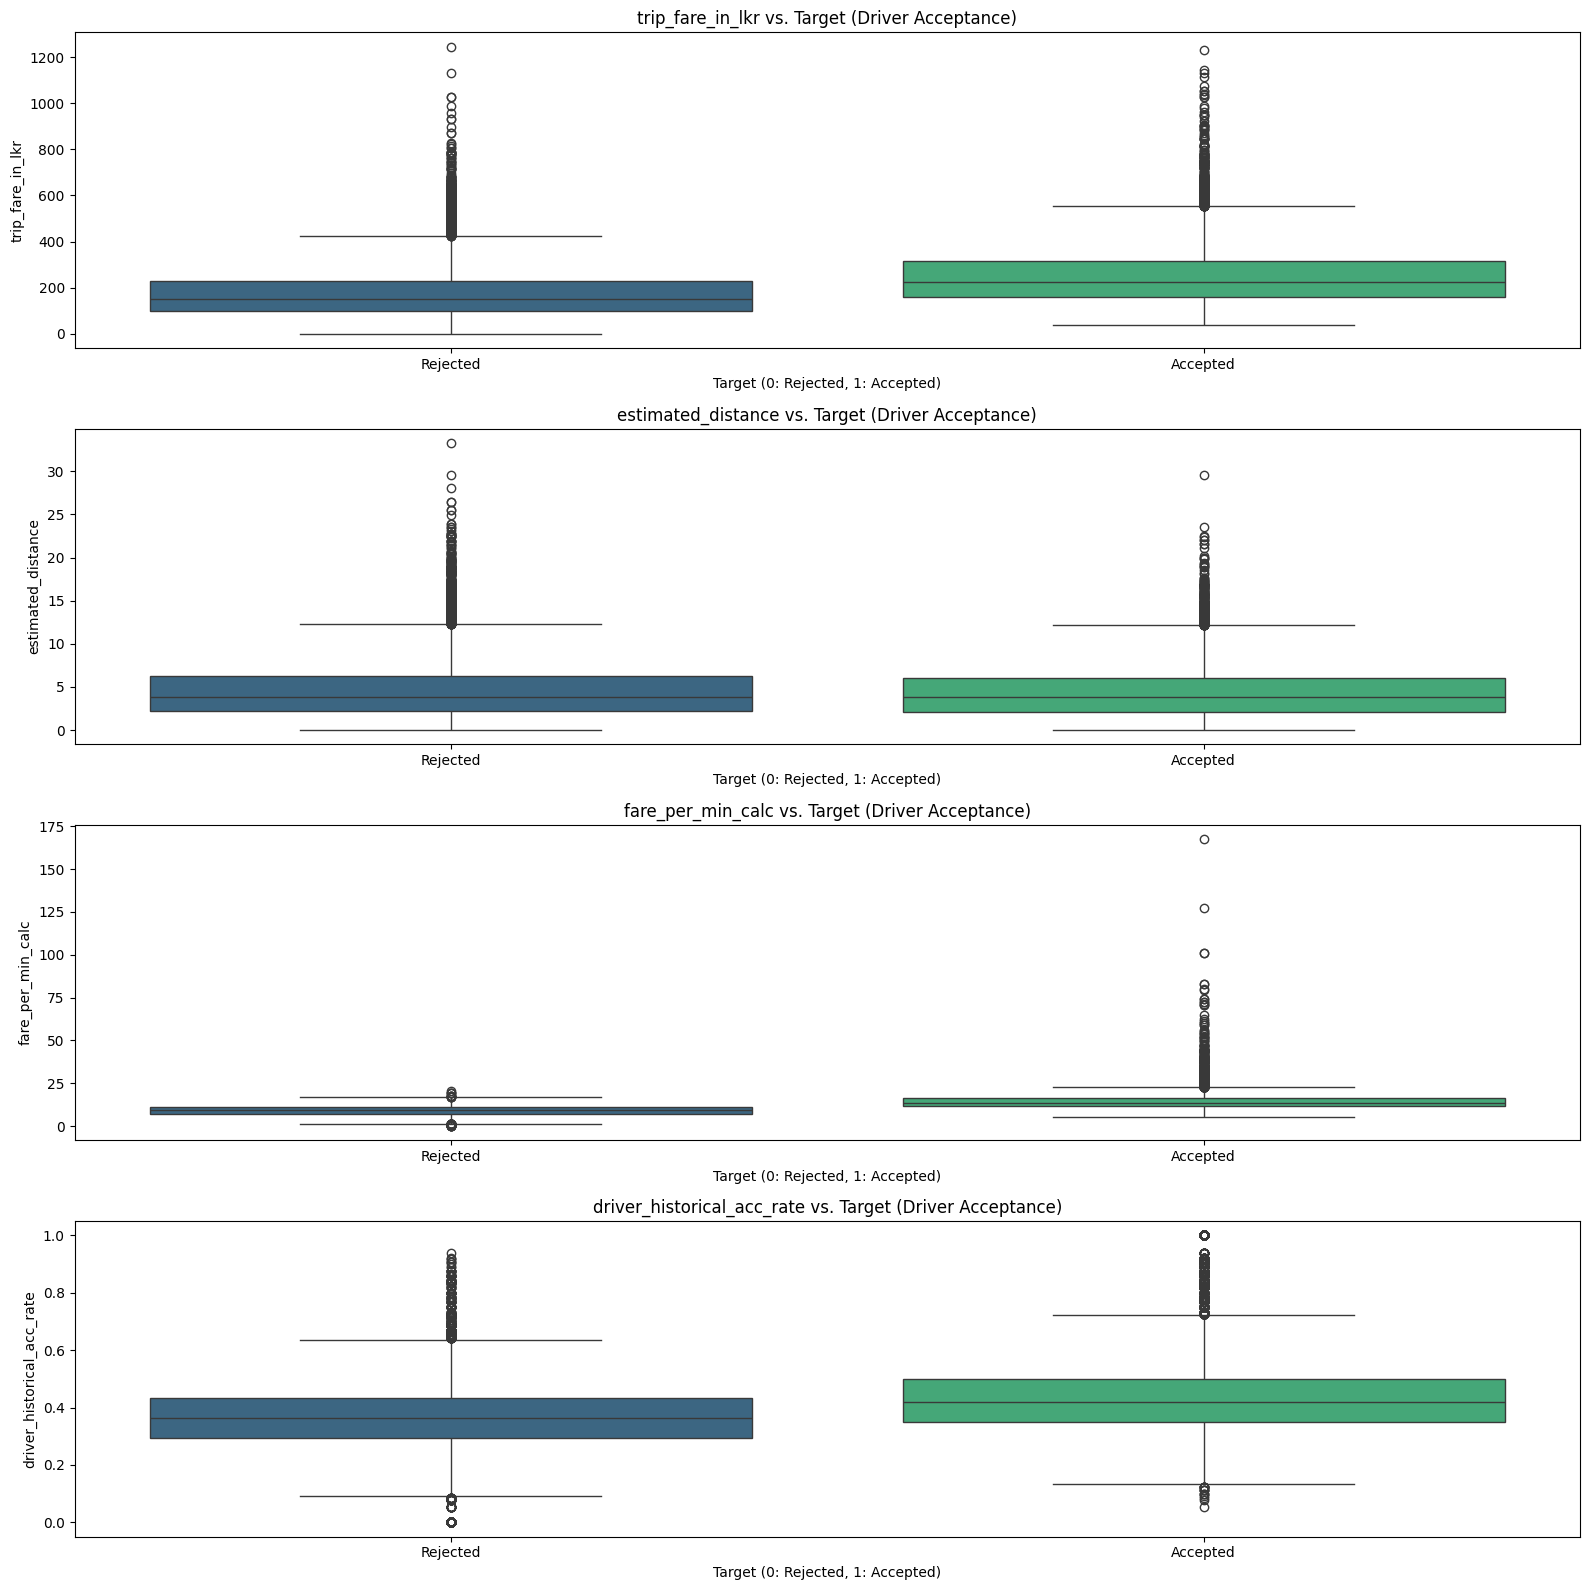

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few key numerical features to visualize against the target
key_numerical_features = ['trip_fare_in_lkr', 'estimated_distance', 'fare_per_min_calc', 'driver_historical_acc_rate']

plt.figure(figsize=(16, 4 * len(key_numerical_features)))
for i, col in enumerate(key_numerical_features):
    plt.subplot(len(key_numerical_features), 1, i + 1)
    sns.boxplot(data=processed_df, x='target', y=col, hue='target', palette='viridis', legend=False)
    plt.title(f'{col} vs. Target (Driver Acceptance)')
    plt.xlabel('Target (0: Rejected, 1: Accepted)')
    plt.ylabel(col)
    plt.xticks([0, 1], ['Rejected', 'Accepted'])
plt.tight_layout()
plt.show()

END of EDA

Starting model training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select the features that now actually contain the signal
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate', 'geo_encoded', 'dist_ordinal'
]

X = processed_df[features]
y = processed_df['target']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



The stratify parameter in train_test_split ensures that the proportion of target classes is approximately the same in both the training and testing sets as it is in the complete dataset. This is particularly useful when dealing with imbalanced datasets, where one class is much more frequent than others. By stratifying, you prevent one set from having a disproportionately high or low number of samples from a particular class, which helps in building more robust models.

Random Forest Classifier

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100}
Random Forest Accuracy: 0.8335
Random Forest Precision: 0.8326
Random Forest Recall: 0.7336
Random Forest F1-Score: 0.7800
Random Forest ROC AUC Score: 0.9160

Random Forest Confusion Matrix:
[[3781  417]
 [ 753 2074]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      4198
           1       0.83      0.73      0.78      2827

    accuracy                           0.83      7025
   macro avg       0.83      0.82      0.82      7025
weighted avg       0.83      0.83      0.83      7025



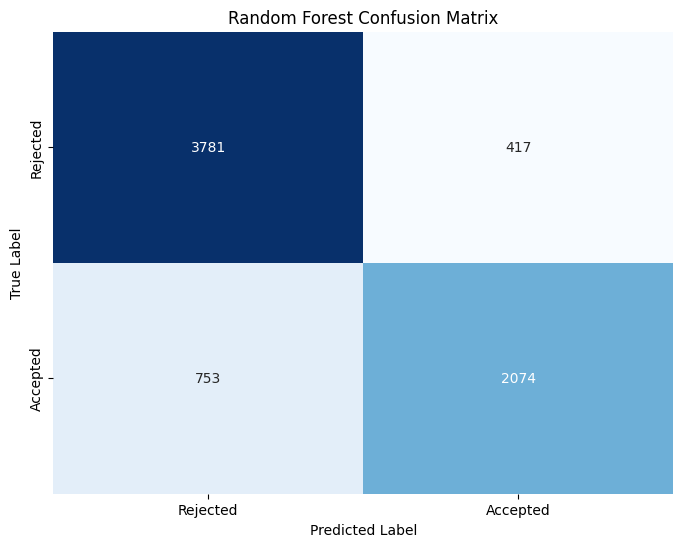

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- START Common Data Prep (duplicated from nq-YWizvBDX9 for robustness) ---
# 1. Select the features that now actually contain the signal
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate', 'geo_encoded', 'dist_ordinal'
]

# Assuming processed_df is available from previous cells.
X = processed_df[features]
y = processed_df['target']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# --- END Common Data Prep ---

# Identify numerical and boolean features
numerical_features = X.select_dtypes(include=np.number).columns
boolean_features = X.select_dtypes(include='bool').columns

# Create preprocessor for numerical and boolean features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bool', OneHotEncoder(handle_unknown='ignore'), boolean_features)
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and RandomForestClassifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],  # Number of trees in the forest
    'classifier__max_depth': [10, 20],      # Maximum depth of the tree
    'classifier__min_samples_leaf': [1, 4] # Minimum number of samples required to be at a leaf node
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print(f"Best parameters for Random Forest: {grid_search.best_params_}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest F1-Score: {f1_rf:.4f}")
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")
print("\nRandom Forest Confusion Matrix:")
print(conf_matrix_rf)
print("\nRandom Forest Classification Report:")
print(class_report_rf)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## XGBoost Classifier

### Subtask:
Provide an in-depth explanation of the XGBoost algorithm, covering its boosting mechanism, regularization techniques, and unique features. Then, train an XGBoost Classifier on the prepared data and evaluate its performance.


**Reasoning**:
To train an XGBoost Classifier, I need to import the required libraries, define the preprocessing steps for numerical and boolean features, create a pipeline, set up a parameter grid for hyperparameter tuning using GridSearchCV, fit the model, and then evaluate its performance using various metrics and visualize the confusion matrix, as per the instructions.



Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for XGBoost: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
XGBoost Accuracy: 0.8346
XGBoost Precision: 0.8315
XGBoost Recall: 0.7386
XGBoost F1-Score: 0.7823
XGBoost ROC AUC Score: 0.9201

XGBoost Confusion Matrix:
[[3775  423]
 [ 739 2088]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4198
           1       0.83      0.74      0.78      2827

    accuracy                           0.83      7025
   macro avg       0.83      0.82      0.82      7025
weighted avg       0.83      0.83      0.83      7025



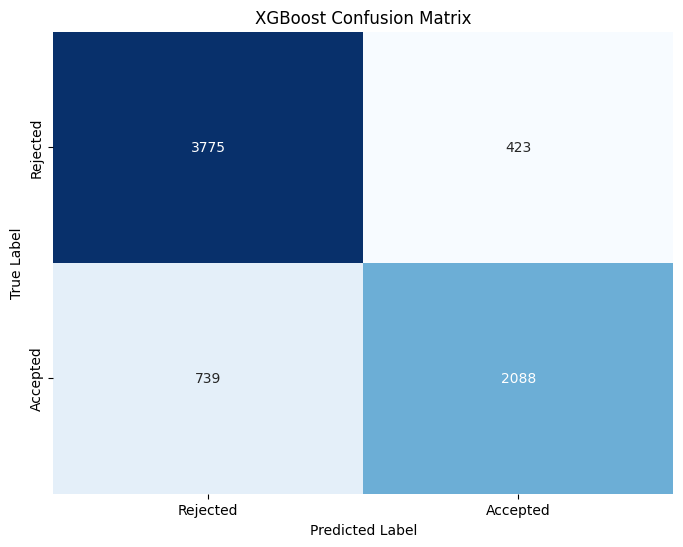

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- START Common Data Prep (duplicated from nq-YWizvBDX9 for robustness) ---
# 1. Select the features that now actually contain the signal
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate', 'geo_encoded', 'dist_ordinal'
]

# Assuming processed_df is available from previous cells.
X = processed_df[features]
y = processed_df['target']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# --- END Common Data Prep ---

# Identify numerical and boolean features
numerical_features = X.select_dtypes(include=np.number).columns
boolean_features = X.select_dtypes(include='bool').columns

# Create preprocessor for numerical and boolean features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bool', OneHotEncoder(handle_unknown='ignore'), boolean_features)
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and XGBClassifier
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],  # Number of boosting rounds
    'classifier__max_depth': [3, 5],        # Maximum depth of a tree
    'classifier__learning_rate': [0.05, 0.1] # Step size shrinkage
}

# Perform GridSearchCV to find the best hyperparameters
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1-Score: {f1_xgb:.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.4f}")
print("\nXGBoost Confusion Matrix:")
print(conf_matrix_xgb)
print("\nXGBoost Classification Report:")
print(class_report_xgb)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Reasoning**:
The previous XGBoost model resulted in `UndefinedMetricWarning` and a confusion matrix showing zero predictions for the 'False' class, indicating a severe class imbalance problem. To address this, I will adjust the `XGBClassifier` by calculating `scale_pos_weight` from the training data (ratio of negative to positive samples) and explicitly setting `objective='binary:logistic'` in the classifier to balance the classes and improve the model's ability to predict the minority class. I will also set `zero_division=0` in the evaluation metrics to suppress warnings.



## LightGBM Classifier


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best parameters for LightGBM: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
LightGBM ROC AUC Score: 0.9191

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4198
           1       0.83      0.74      0.78      2827

    accuracy                           0.83      7025
   macro avg       0.83      0.82      0.82      7025
weighted avg       0.83      0.83      0.83      7025



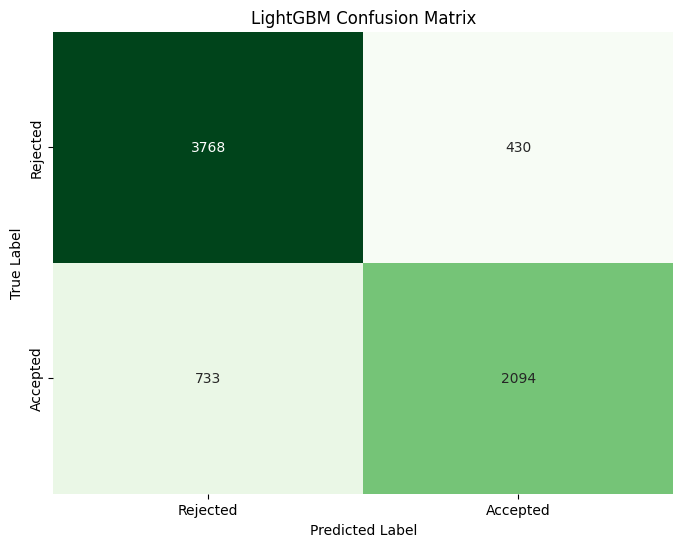

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV # Added train_test_split and GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Added StandardScaler and OneHotEncoder
from sklearn.compose import ColumnTransformer # Added ColumnTransformer
from sklearn.pipeline import Pipeline # Added Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Added numpy for select_dtypes

# --- START Common Data Prep (duplicated from nq-YWizvBDX9 for robustness) ---
# 1. Select the features that now actually contain the signal
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate', 'geo_encoded', 'dist_ordinal'
]

# Assuming processed_df is available from previous cells.
X = processed_df[features]
y = processed_df['target']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# --- END Common Data Prep ---

# Identify numerical and boolean features (re-defined here for robustness)
numerical_features = X.select_dtypes(include=np.number).columns
boolean_features = X.select_dtypes(include='bool').columns

# Create preprocessor for numerical and boolean features (re-defined here for robustness)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bool', OneHotEncoder(handle_unknown='ignore'), boolean_features)
    ],
    remainder='passthrough'
)

# 1. Create Pipeline
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42, verbosity=-1))
])

# 2. Grid Search
param_grid_lgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [31, 50]
}
grid_search_lgb = GridSearchCV(lgb_pipeline, param_grid_lgb, cv=3, scoring='f1', n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)

# 3. Predictions
best_lgb_model = grid_search_lgb.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)
y_proba_lgb = best_lgb_model.predict_proba(X_test)[:, 1]

# 4. Evaluation & Reports
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb) # Calculate ROC AUC
print(f"Best parameters for LightGBM: {grid_search_lgb.best_params_}")
print(f"LightGBM ROC AUC Score: {roc_auc_lgb:.4f}") # Print ROC AUC
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# 5. Plot Confusion Matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'])
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()





# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_lgb)
precision_xgb = precision_score(y_test, y_pred_lgb)
recall_xgb = recall_score(y_test, y_pred_lgb)
f1_xgb = f1_score(y_test, y_pred_lgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_lgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_lgb)
class_report_xgb = classification_report(y_test, y_pred_lgb)

print(f"Best parameters for XGBoost: {grid_search_lgb.best_params_}")
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1-Score: {f1_xgb:.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.4f}")

Best parameters for XGBoost: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
XGBoost Accuracy: 0.8344
XGBoost Precision: 0.8296
XGBoost Recall: 0.7407
XGBoost F1-Score: 0.7827
XGBoost ROC AUC Score: 0.9191

XGBoost Confusion Matrix:


## CatBoost Classifier


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


Best parameters for CatBoost: {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__learning_rate': 0.1}
CatBoost ROC AUC Score: 0.9201

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4198
           1       0.84      0.74      0.78      2827

    accuracy                           0.84      7025
   macro avg       0.84      0.82      0.82      7025
weighted avg       0.84      0.84      0.83      7025



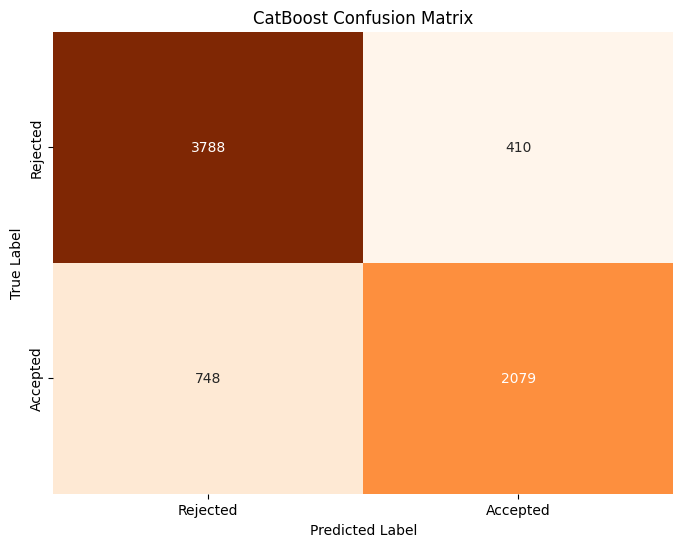

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV # Added train_test_split and GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Added StandardScaler and OneHotEncoder
from sklearn.compose import ColumnTransformer # Added ColumnTransformer
from sklearn.pipeline import Pipeline # Added Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # Added roc_auc_score
import matplotlib.pyplot as plt # Added for plotting
import seaborn as sns # Added for plotting
import numpy as np # Added for select_dtypes

# --- START Common Data Prep (duplicated from nq-YWizvBDX9 for robustness) ---
# 1. Select the features that now actually contain the signal
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate', 'geo_encoded', 'dist_ordinal'
]

# Assuming processed_df is available from previous cells.
X = processed_df[features]
y = processed_df['target']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# --- END Common Data Prep ---

# Identify numerical and boolean features (re-defined here for robustness)
numerical_features = X.select_dtypes(include=np.number).columns
boolean_features = X.select_dtypes(include='bool').columns

# Create preprocessor for numerical and boolean features (re-defined here for robustness)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bool', OneHotEncoder(handle_unknown='ignore'), boolean_features)
    ],
    remainder='passthrough'
)

# 1. Create Pipeline
cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=42, verbose=0))
])

# 2. Grid Search
param_grid_cat = {
    'classifier__iterations': [100, 200],
    'classifier__depth': [4, 6],
    'classifier__learning_rate': [0.05, 0.1]
}
grid_search_cat = GridSearchCV(cat_pipeline, param_grid_cat, cv=3, scoring='f1', n_jobs=-1)
grid_search_cat.fit(X_train, y_train)

# 3. Predictions
best_cat_model = grid_search_cat.best_estimator_
y_pred_cat = best_cat_model.predict(X_test)
y_proba_cat = best_cat_model.predict_proba(X_test)[:, 1]

# 4. Evaluation & Reports
roc_auc_cat = roc_auc_score(y_test, y_proba_cat) # Calculate ROC AUC
print(f"Best parameters for CatBoost: {grid_search_cat.best_params_}")
print(f"CatBoost ROC AUC Score: {roc_auc_cat:.4f}") # Print ROC AUC
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))

# 5. Plot Confusion Matrix
conf_matrix_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cat, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'])
plt.title('CatBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Evaluate the model
accuracy_cat = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat)
recall_cat = recall_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)
roc_auc_cat = roc_auc_score(y_test, y_proba_cat)
conf_matrix_cat = confusion_matrix(y_test, y_pred_cat)
class_report_cat = classification_report(y_test, y_pred_cat)

print(f"Best parameters for XGBoost: {grid_search_lgb.best_params_}")
print(f"XGBoost Accuracy: {accuracy_cat:.4f}")
print(f"XGBoost Precision: {precision_cat:.4f}")
print(f"XGBoost Recall: {recall_cat:.4f}")
print(f"XGBoost F1-Score: {f1_cat:.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_cat:.4f}")

Best parameters for XGBoost: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
XGBoost Accuracy: 0.8352
XGBoost Precision: 0.8353
XGBoost Recall: 0.7354
XGBoost F1-Score: 0.7822
XGBoost ROC AUC Score: 0.9201


In [ ]:
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.4f}")
print(f"LightGBM ROC AUC Score: {roc_auc_lgb:.4f}")
print(f"CatBoost ROC AUC Score: {roc_auc_cat:.4f}")

Random Forest ROC AUC Score: 0.9160
XGBoost ROC AUC Score: 0.9201
LightGBM ROC AUC Score: 0.9191
CatBoost ROC AUC Score: 0.9201


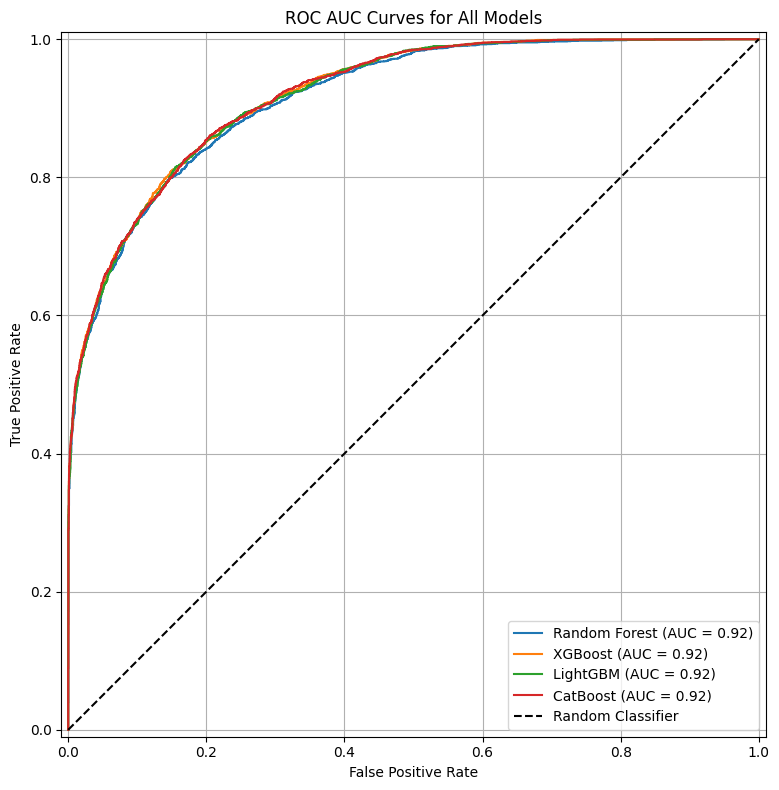

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 8))

# Plot ROC curve for Random Forest
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name=f"Random Forest", ax=plt.gca())

# Plot ROC curve for XGBoost
RocCurveDisplay.from_predictions(y_test, y_proba_xgb, name=f"XGBoost", ax=plt.gca())

# Plot ROC curve for LightGBM
RocCurveDisplay.from_predictions(y_test, y_proba_lgb, name=f"LightGBM", ax=plt.gca())

# Plot ROC curve for CatBoost
RocCurveDisplay.from_predictions(y_test, y_proba_cat, name=f"CatBoost", ax=plt.gca())

plt.title('ROC AUC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Diagonal line for reference
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=578fb338004517443a172efd9fc0a00b2d94729504e2b27a742175380fd78789
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import shap
import lime
import lime.lime_tabular
import pandas as pd

# 1. Get feature names from the preprocessor (after OneHotEncoding)
# This ensures we see 'bool_feature_1' instead of just 'column 5'
feature_names = best_xgb_model.named_steps['preprocessor'].get_feature_names_out()

# 2. Transform the data for the explainers
# Explainers often need the processed (numerical) version of the data
X_test_transformed = best_xgb_model.named_steps['preprocessor'].transform(X_test)
X_train_transformed = best_xgb_model.named_steps['preprocessor'].transform(X_train)


--- SHAP Summary Plot for XGBoost ---


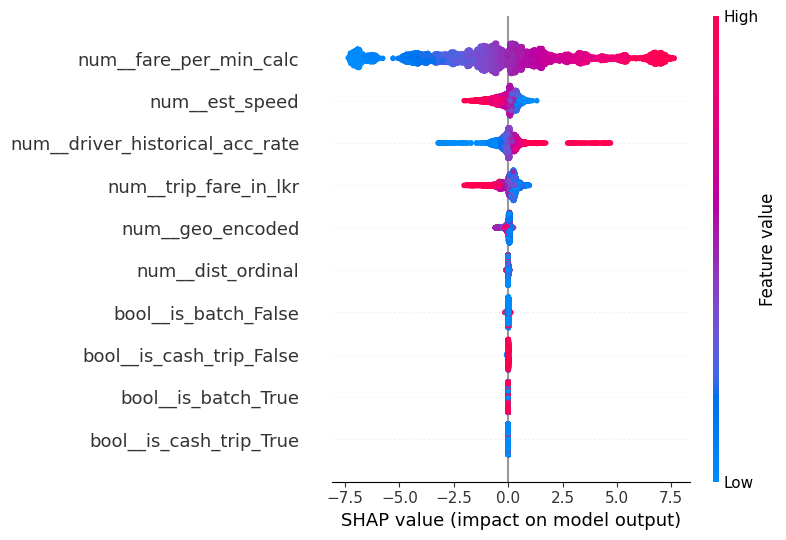

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



--- SHAP Summary Plot for LightGBM ---


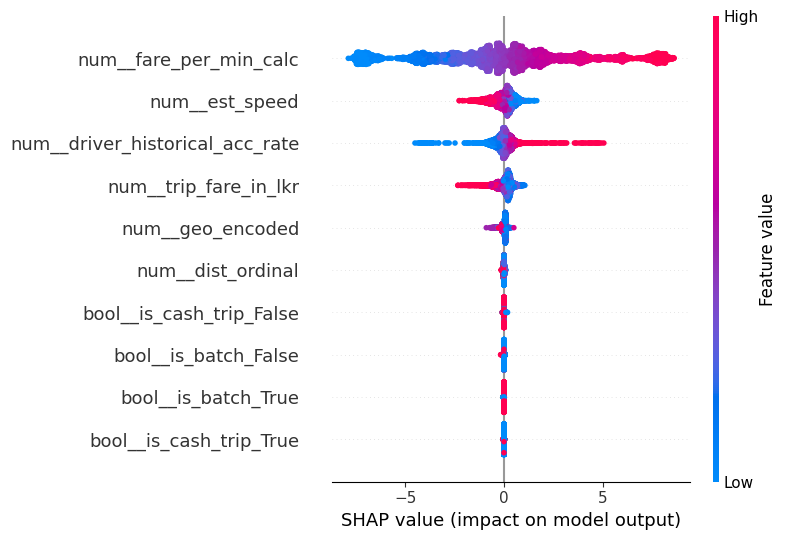


--- SHAP Summary Plot for CatBoost ---


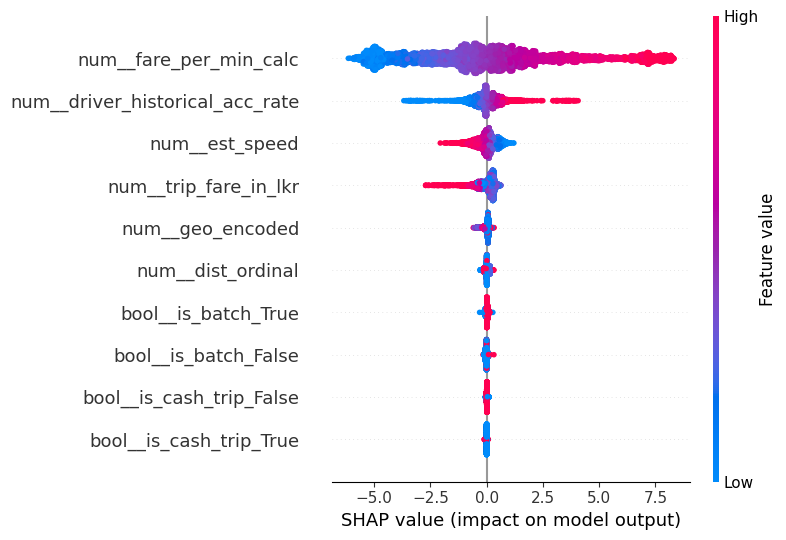

In [ ]:
# Function to run SHAP for any of your models
def run_shap(model_pipeline, X_transformed, feature_names, model_name="Model"):
    # Extract the actual classifier from the pipeline
    model = model_pipeline.named_steps['classifier']

    # Create the Explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_transformed)

    print()

    # Plot Summary (Beeswarm)
    print(f"--- SHAP Summary Plot for {model_name} ---")
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

# Execute for all three
run_shap(best_xgb_model, X_test_transformed, feature_names, "XGBoost")
run_shap(best_lgb_model, X_test_transformed, feature_names, "LightGBM")
run_shap(best_cat_model, X_test_transformed, feature_names, "CatBoost")

In [ ]:
# 1. Setup the LIME Explainer
# Use the training data to let LIME learn the feature distributions
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=feature_names,
    class_names=['Rejected', 'Accepted'],
    mode='classification'
)

# 2. Pick a specific instance to explain (e.g., the first person in test set)
i = 0
instance = X_test_transformed[i]

# 3. Explain the XGBoost prediction for this person
# We use the classifier's predict_proba function
exp = lime_explainer.explain_instance(
    instance,
    best_xgb_model.named_steps['classifier'].predict_proba,
    num_features=5
)

print(f"LIME Explanation for Instance {i}:")
exp.show_in_notebook(show_table=True)
# If not in a notebook, use: exp.as_pyplot_figure(); plt.show()

LIME Explanation for Instance 0:


In [ ]:
import pickle

# Define a dictionary of models to save
models_to_save = {
    'random_forest_model': best_rf_model,
    'xgboost_model': best_xgb_model,
    'lightgbm_model': best_lgb_model,
    'catboost_model': best_cat_model
}

# Save each model in pickle format
for model_name, model_pipeline in models_to_save.items():
    filename = f'{model_name}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model_pipeline, file)
    print(f'Model saved: {filename}')

print("All models saved successfully in pickle format.")

Model saved: random_forest_model.pkl
Model saved: xgboost_model.pkl
Model saved: lightgbm_model.pkl
Model saved: catboost_model.pkl
All models saved successfully in pickle format.


In [ ]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

# Re-define features and split data for robustness, similar to previous cells
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate', 'geo_encoded', 'dist_ordinal'
]

# Assuming processed_df is available from previous cells.
X = processed_df[features]
y = processed_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the paths to the saved models
model_filenames = {
    'random_forest': 'random_forest_model.pkl',
    'xgboost': 'xgboost_model.pkl',
    'lightgbm': 'lightgbm_model.pkl',
    'catboost': 'catboost_model.pkl'
}

loaded_models = {}
predictions = {}
probabilities = {}

# Load each model and make predictions
for name, filename in model_filenames.items():
    print(f"Loading {name} model from {filename}...")
    with open(filename, 'rb') as file:
        loaded_model = pickle.load(file)
    loaded_models[name] = loaded_model
    print(f"Making predictions with {name} model...")
    predictions[name] = loaded_model.predict(X_test)
    probabilities[name] = loaded_model.predict_proba(X_test)[:, 1] # Probability of the positive class
    print(f"{name} predictions generated.")

print("\n--- Predictions Summary ---")
for name in loaded_models.keys():
    print(f"\n{name} Model:")
    print(f"  First 5 predictions: {predictions[name][:5]}")
    print(f"  First 5 probabilities (positive class): {probabilities[name][:5]}")


Loading random_forest model from random_forest_model.pkl...
Making predictions with random_forest model...
random_forest predictions generated.
Loading xgboost model from xgboost_model.pkl...
Making predictions with xgboost model...
xgboost predictions generated.
Loading lightgbm model from lightgbm_model.pkl...
Making predictions with lightgbm model...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm predictions generated.
Loading catboost model from catboost_model.pkl...
Making predictions with catboost model...
catboost predictions generated.

--- Predictions Summary ---

random_forest Model:
  First 5 predictions: [1 0 1 0 1]
  First 5 probabilities (positive class): [0.55965935 0.49702013 0.98266465 0.25804663 0.86317448]

xgboost Model:
  First 5 predictions: [1 0 1 0 1]
  First 5 probabilities (positive class): [0.5561221  0.34314966 0.99214864 0.25647876 0.8647367 ]

lightgbm Model:
  First 5 predictions: [1 0 1 0 1]
  First 5 probabilities (positive class): [0.56692506 0.39575947 0.99050763 0.2459407  0.86935379]

catboost Model:
  First 5 predictions: [1 0 1 0 1]
  First 5 probabilities (positive class): [0.60108243 0.32991848 0.99361631 0.27764863 0.85948438]


Enhancements

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Feature set
features = [
    'trip_fare_in_lkr', 'is_cash_trip', 'is_batch', 'est_speed',
    'fare_per_min_calc', 'driver_historical_acc_rate',
    'geo_encoded', 'dist_ordinal'
]

X = processed_df[features]
y = processed_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Tree-friendly preprocessing
numerical_features = X.select_dtypes(include=np.number).columns
boolean_features = X.select_dtypes(include='bool').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('bool', 'passthrough', boolean_features)
    ]
)


RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

param_grid_rf = {
    'classifier__n_estimators': [300, 500],
    'classifier__max_depth': [15, 25, None],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['sqrt', 0.7]
}

grid_rf = GridSearchCV(
    rf_pipeline, param_grid_rf,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.42).astype(int)

print("Random Forest")
print("Best Params:", grid_rf.best_params_)
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest
Best Params: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 500}
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4198
           1       0.74      0.84      0.79      2827

    accuracy                           0.82      7025
   macro avg       0.81      0.82      0.81      7025
weighted avg       0.82      0.82      0.82      7025

ROC AUC: 0.9137576335051322


XG

In [ ]:
import xgboost as xgb

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
    ))
])

param_grid_xgb = {
    'classifier__n_estimators': [300, 500],
    'classifier__max_depth': [6, 8],
    'classifier__learning_rate': [0.03, 0.05],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 0.9]
}

grid_xgb = GridSearchCV(
    xgb_pipeline, param_grid_xgb,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.42).astype(int)

print("XGBoost")
print("Best Params:", grid_xgb.best_params_)
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
XGBoost
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.03, 'classifier__max_depth': 6, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4198
           1       0.74      0.85      0.79      2827

    accuracy                           0.82      7025
   macro avg       0.81      0.83      0.82      7025
weighted avg       0.83      0.82      0.82      7025

ROC AUC: 0.9197630704263472


Lite

In [ ]:
import lightgbm as lgb

lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        verbosity=-1
    ))
])

param_grid_lgb = {
    'classifier__n_estimators': [300, 500],
    'classifier__learning_rate': [0.03, 0.05],
    'classifier__num_leaves': [63, 100],
    'classifier__max_depth': [-1, 10],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
}

grid_lgb = GridSearchCV(
    lgb_pipeline, param_grid_lgb,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)

grid_lgb.fit(X_train, y_train)
best_lgb = grid_lgb.best_estimator_

y_proba_lgb = best_lgb.predict_proba(X_test)[:, 1]
y_pred_lgb = (y_proba_lgb >= 0.42).astype(int)

print("LightGBM")
print("Best Params:", grid_lgb.best_params_)
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lgb))


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.03, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__num_leaves': 63, 'classifier__subsample': 0.8}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4198
           1       0.74      0.85      0.79      2827

    accuracy                           0.82      7025
   macro avg       0.81      0.82      0.82      7025
weighted avg       0.83      0.82      0.82      7025

ROC AUC: 0.9166741519408992


Cat

In [ ]:
from catboost import CatBoostClassifier

cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        loss_function='Logloss',
        random_state=42,
        verbose=0,
        class_weights=[
            1,
            y_train.value_counts()[0] / y_train.value_counts()[1]
        ]
    ))
])

param_grid_cat = {
    'classifier__iterations': [300, 500],
    'classifier__depth': [6, 8],
    'classifier__learning_rate': [0.03, 0.05]
}

grid_cat = GridSearchCV(
    cat_pipeline, param_grid_cat,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)

grid_cat.fit(X_train, y_train)
best_cat = grid_cat.best_estimator_

y_proba_cat = best_cat.predict_proba(X_test)[:, 1]
y_pred_cat = (y_proba_cat >= 0.42).astype(int)

print("CatBoost")
print("Best Params:", grid_cat.best_params_)
print(classification_report(y_test, y_pred_cat))
print("ROC AUC:", roc_auc_score(y_test, y_proba_cat))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CatBoost
Best Params: {'classifier__depth': 6, 'classifier__iterations': 300, 'classifier__learning_rate': 0.03}
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      4198
           1       0.73      0.86      0.79      2827

    accuracy                           0.82      7025
   macro avg       0.81      0.83      0.82      7025
weighted avg       0.83      0.82      0.82      7025

ROC AUC: 0.920372958774143


Stacking


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=25,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
    random_state=42,
    n_jobs=-1
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=80,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    verbosity=-1
)

cat_model = CatBoostClassifier(
    iterations=400,
    depth=7,
    learning_rate=0.05,
    loss_function='Logloss',
    class_weights=[1, y_train.value_counts()[0] / y_train.value_counts()[1]],
    random_state=42,
    verbose=0
)


In [ ]:
from sklearn.pipeline import Pipeline

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

lgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb_model)
])

cat_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', cat_model)
])


In [ ]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)


In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_pipe),
        ('xgb', xgb_pipe),
        ('lgb', lgb_pipe),
        ('cat', cat_pipe)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',
    passthrough=False,
    cv=5,
    n_jobs=-1
)


In [ ]:
stacking_clf.fit(X_train, y_train)

y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]

# Threshold tuning
threshold = 0.42
y_pred_stack = (y_proba_stack >= threshold).astype(int)

print("STACKING ENSEMBLE RESULTS")
print(classification_report(y_test, y_pred_stack))
print("ROC AUC:", roc_auc_score(y_test, y_proba_stack))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


STACKING ENSEMBLE RESULTS
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4198
           1       0.74      0.85      0.79      2827

    accuracy                           0.82      7025
   macro avg       0.82      0.83      0.82      7025
weighted avg       0.83      0.82      0.82      7025

ROC AUC: 0.9187383602581316
